In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fonts = fm.findSystemFonts()

for font in fonts:
    fm.fontManager.addfont(font)

font_size = 11
font_family = 'Sono'
plot_style = 'seaborn-v0_8-paper'

plt.style.use(plot_style)
plt.rcParams['grid.alpha'] = 0.25
plt.rcParams['font.family'] = font_family
plt.rcParams['font.size'] = font_size
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['legend.fontsize'] = font_size
plt.rcParams['figure.titlesize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 1
# plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.spines.right'] = False
plt.rcParams['figure.constrained_layout.use'] = True

In [11]:
def create_composite_feature(dataframe, feature_list, new_feature_name, drop_features=False):
    """
    Create a composite feature from a list of features.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe containing the features.
    feature_list : list
        The list of features to combine.
    new_feature_name : str
        The name of the new feature.
    drop_features : bool, default False
        Whether to drop the features used to create the new feature.
        
    Returns
    -------
    dataframe : pandas.DataFrame
        The dataframe with the new feature added.
    """    
    dataframe[new_feature_name] = dataframe[feature_list].mean(axis=1)
    if drop_features:
        dataframe.drop(columns=feature_list, inplace=True)
    return dataframe


def engineer_change_features(dataframe, drop_before_after=False):
    """
    Create change features from before and after features.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe containing the features.
    drop_before_after : bool, default False
        Whether to drop the before and after features.
        
    Returns
    -------
    dataframe : pandas.DataFrame
        The dataframe with the change features added.
        
    Notes
    -----
    The change features are created by subtracting the before feature from the after feature.
    
    The change features are inserted after the after feature.
    
    Examples
    --------
    >>> import pandas as pd
    >>> df = pd.DataFrame({'a_before': [1, 2, 3],
                           'a_after': [4, 5, 6],
                           'b_before': [7, 8, 9],
                           'b_after': [10, 11, 12]})
    >>> df = engineer_change_features(df)
    """
    for col in dataframe.columns:
        if col.endswith('_before') or col.endswith('_after'):
            base_col = col.rsplit('_', 1)[0]
            before_col = base_col + '_before'
            after_col = base_col + '_after'
            if before_col in dataframe.columns and after_col in dataframe.columns:
                change_col = base_col + '_change'
                dataframe[change_col] = dataframe[after_col] - dataframe[before_col]
                change_col_index = max(dataframe.columns.get_loc(before_col), dataframe.columns.get_loc(after_col)) + 1
                change_col_data = dataframe[change_col]
                dataframe.drop(columns=[change_col], inplace=True)
                dataframe.insert(change_col_index, change_col, change_col_data)
                if drop_before_after:
                    dataframe.drop(columns=[before_col, after_col], inplace=True)
    return dataframe

In [12]:
survey = pd.read_excel('../data/raw/NARIG_Survey.xlsx', usecols='A:EG')
column_names = pd.read_json('../data/processed/json/column_names.json', typ='series')

kenya = gpd.read_file('../data/processed/geojson/kenya.geojson')
counties = gpd.read_file('../data/processed/geojson/kenya_counties.geojson')
sub_counties = gpd.read_file('../data/processed/geojson/kenya_sub_counties.geojson')
wards = gpd.read_file('../data/processed/geojson/kenya_wards.geojson')
makueni_county = counties[counties['county'] == 'Makueni']
makueni_sub_counties = sub_counties[sub_counties['county'] == 'Makueni']
makueni_wards = wards[wards['county'] == 'Makueni']

survey.rename(columns=column_names, inplace=True)

replace_map = {'Diasgree': 'Disagree',
               '6+': 6,
               'Kako': 'Waia/Kako',
               'Mtito': 'Mtito Andei'}

ordinal_map = {'Strongly Agree': 5,
               'Agree': 4,
               'Neutral': 3,
               'Disagree': 2,
               'Strongly Disagree': 1}

reverse_map = {v: k for k, v in ordinal_map.items()}

survey = makueni_wards.merge(survey, on='ward', how='left')

survey.replace(replace_map, inplace=True)
survey.replace(ordinal_map, inplace=True)

survey['age'] = survey['age'].replace(0, np.nan)
survey['gender'] = survey['gender'].str.split().str[-1]

orig_col_order = list(survey.columns)

demographic_cols = survey.columns[:9].tolist()
attitude_cols = survey.columns[9:17].tolist()
knowledge_cols = survey.columns[17:22].tolist()
practice_cols = survey.columns[22:27].tolist()
vc_performance_cols = survey.columns[27:-6].tolist()
performance_cols = survey.columns[-6:].tolist()

value_chains = list(survey['value_chain'].unique())

narig_dfs = {vc: survey[survey['value_chain'] == vc].dropna(axis=1, how='all') for vc in value_chains}

for k, v in narig_dfs.items():
    v.columns = v.columns.str.replace('_\d', '', regex=True)
    # v.dropna(axis=0, inplace=True)
    # v = create_composite_feature(v, attitude_cols, 'farmer_attitudes')
    # v = create_composite_feature(v, knowledge_cols, 'farmer_knowledge')
    # v = create_composite_feature(v, practice_cols, 'farmer_practices')
    # v = create_composite_feature(v, performance_cols, 'project_performance')
    # v = engineer_change_features(v)

narig_dfs['survey_df'] = pd.concat(narig_dfs.values(), ignore_index=True)
narig_dfs['survey_df'] = narig_dfs['survey_df'][[col for col in orig_col_order if col in narig_dfs['survey_df'].columns]]

narig_dfs['survey_df'].replace(reverse_map, inplace=True)
numeric_cols = narig_dfs['survey_df'].select_dtypes('number').columns.tolist()
narig_dfs['survey_df'].replace(ordinal_map, inplace=True)

narig_dfs['survey_df'] = engineer_change_features(narig_dfs['survey_df'], drop_before_after=False)
# narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], attitude_cols, 'farmer_attitudes', drop_features=False)
# narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], knowledge_cols, 'farmer_knowledge', drop_features=False)
# narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], practice_cols, 'farmer_practices', drop_features=False)
narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], performance_cols, 'project_performance', drop_features=False)

for k, v in narig_dfs.items():
    for col in v.select_dtypes('object').columns:
        v[col] = v[col].astype('category')
    for col in v.select_dtypes('float').columns:
        if v[col].apply(float.is_integer).all():
            v[col] = v[col].astype(int)
    print(k)
    
display(narig_dfs['survey_df'].info(), narig_dfs['survey_df'].head())

Tomato
Indigenous chicken
Mango
nan
Green gram
survey_df
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 95 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   county                              151 non-null    category
 1   sub_county                          151 non-null    category
 2   ward                                151 non-null    category
 3   geometry                            151 non-null    geometry
 4   gender                              151 non-null    category
 5   age                                 151 non-null    int32   
 6   education                           151 non-null    category
 7   monthly_income                      151 non-null    int32   
 8   household_size                      151 non-null    int32   
 9   family_head                         151 non-null    category
 10  value_chain                      

None

,county,sub_county,ward,geometry,gender,age,education,monthly_income,household_size,family_head,...,adopted_vaccination,trained_hygiene_management,adopted_hygiene_management,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity,project_performance
0,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,64,Secondary,30000,3,Yes,...,NaN,NaN,NaN,5,5,4,5,5,5,4.833333
1,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,67,Secondary,20000,4,Yes,...,NaN,NaN,NaN,5,5,5,5,5,5,5.000000
2,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,33,Primary,5000,3,No,...,NaN,NaN,NaN,5,5,5,5,5,5,5.000000
3,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,73,Primary,800,6,No,...,NaN,NaN,NaN,5,5,4,5,5,5,4.833333
4,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,71,Secondary,10000,5,Yes,...,NaN,NaN,NaN,5,5,5,5,5,5,5.000000


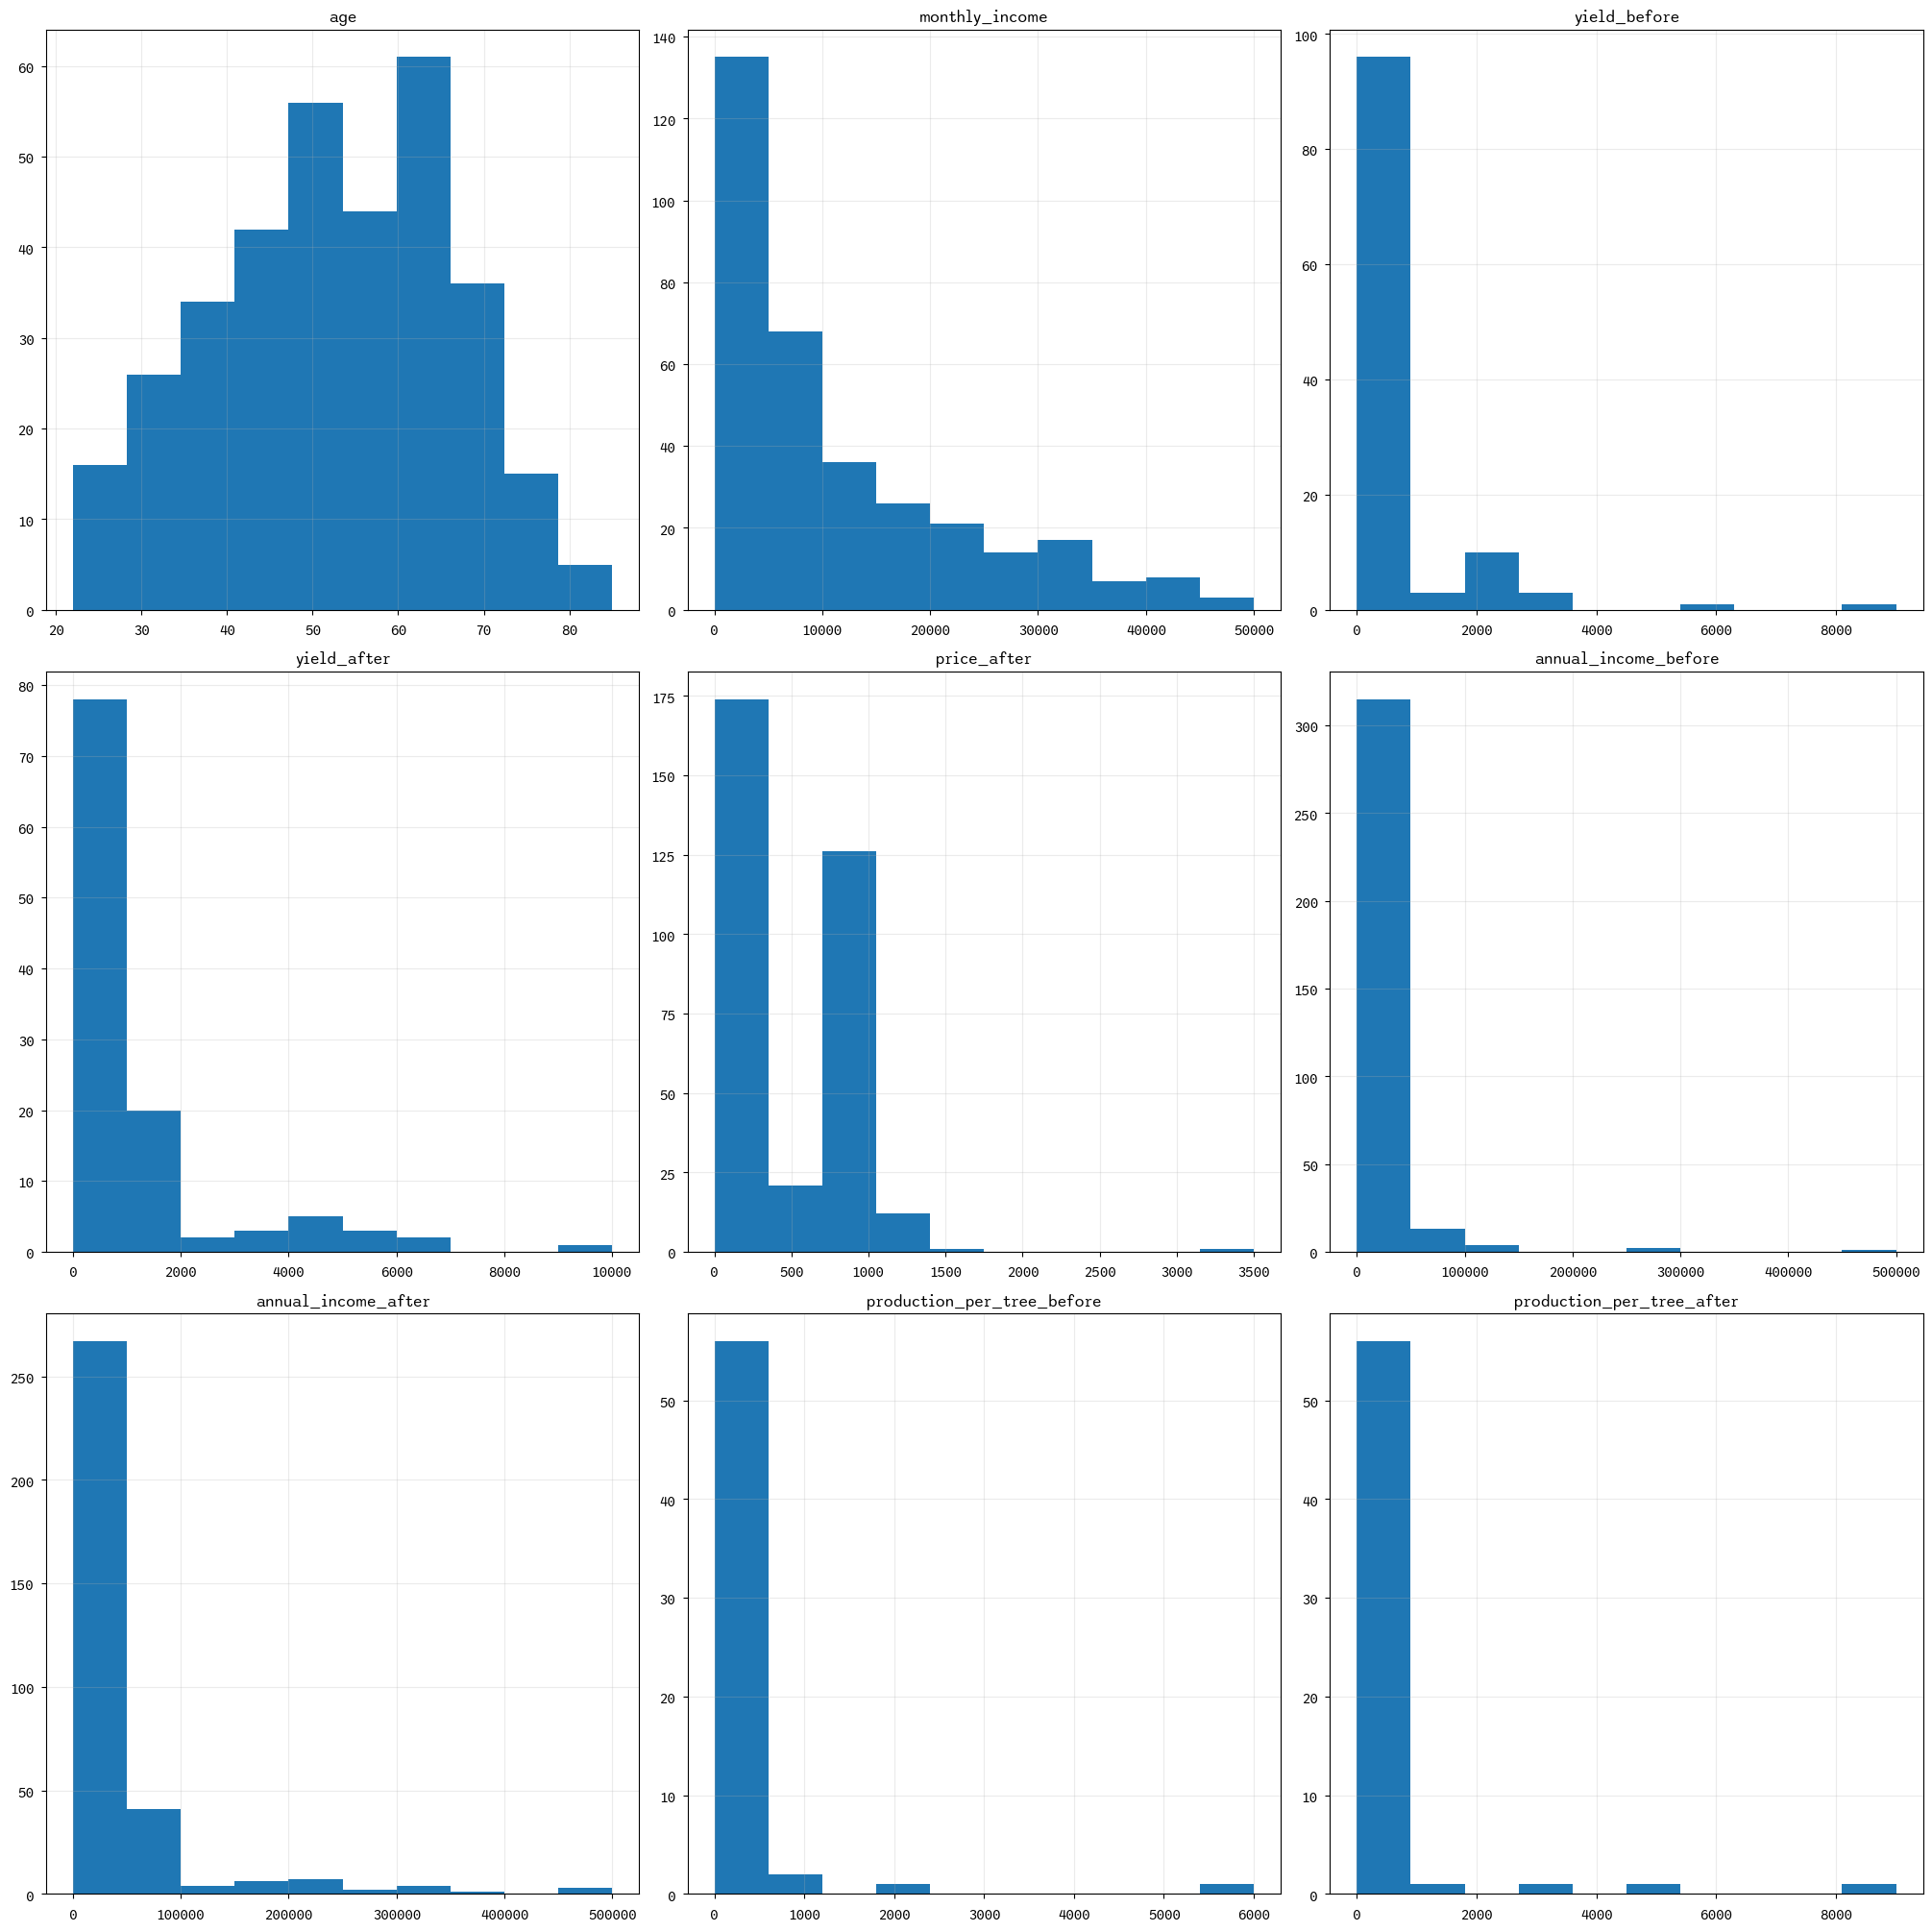

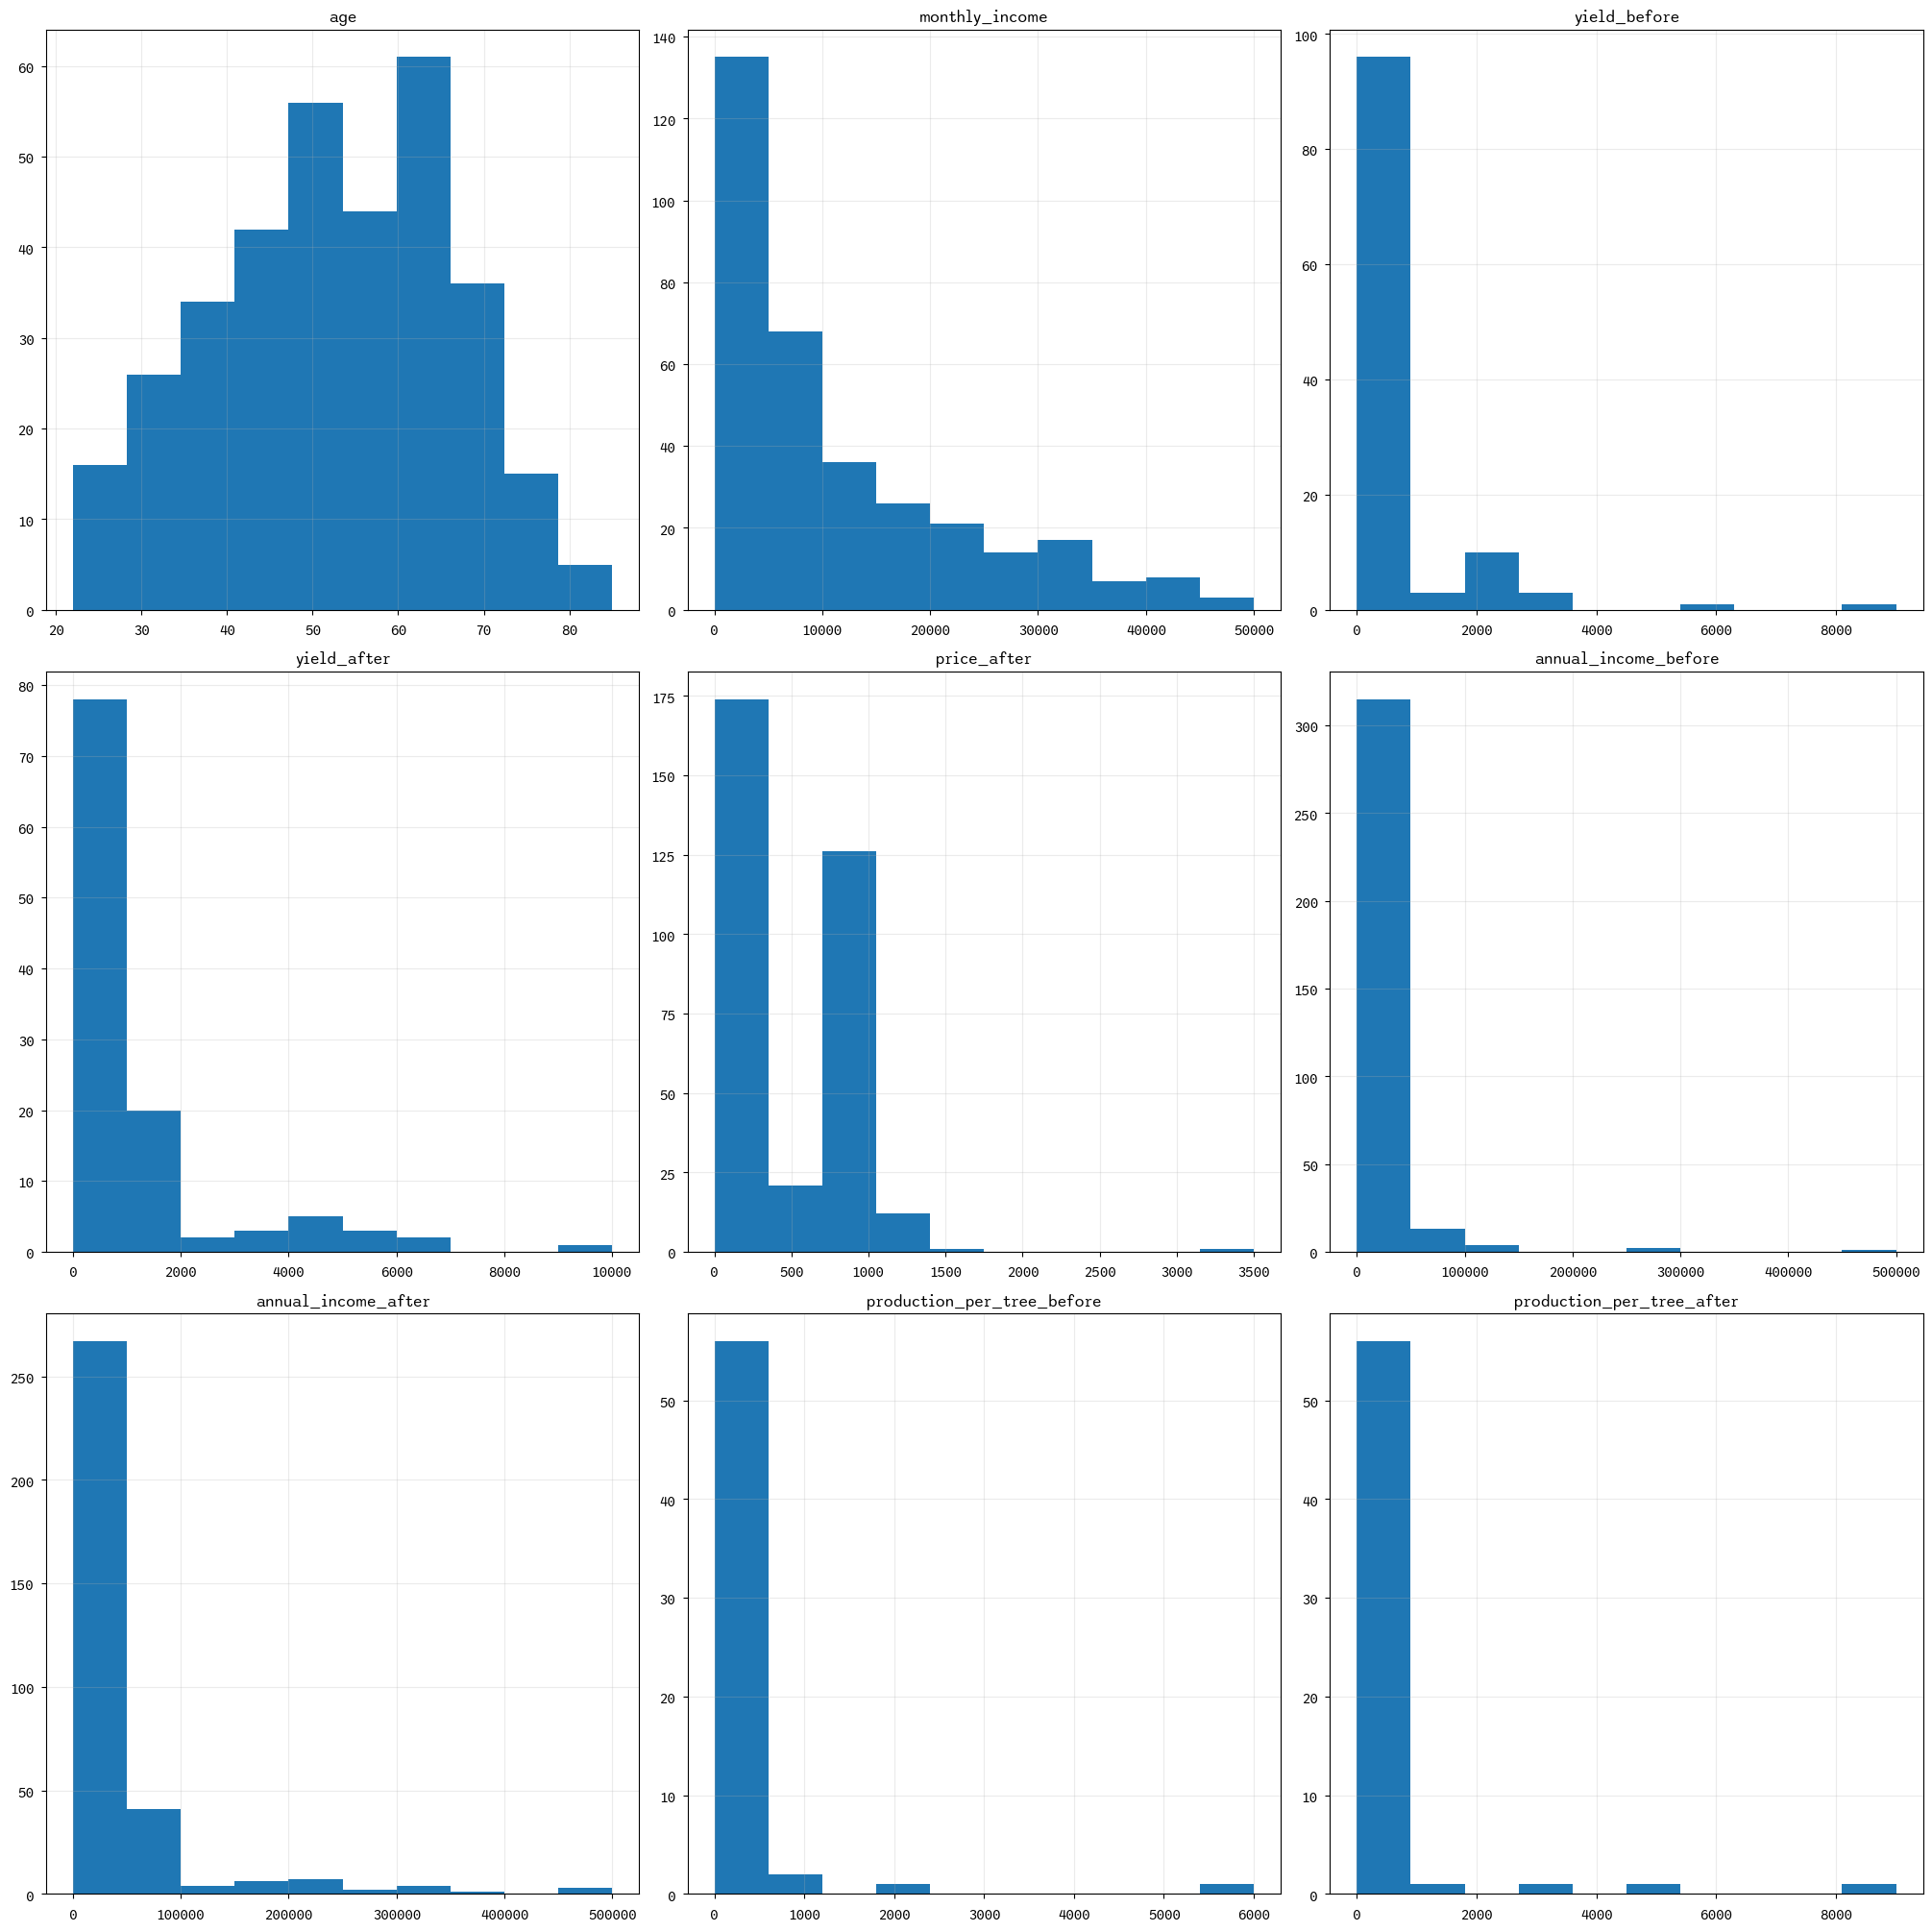

In [44]:
narig_dfs['survey_df'][numeric_cols].hist(figsize=(20,20))
plt.show()


def filter_outliers(dataframe: pd.DataFrame, columns: list):
    
    for col in columns:
        
        mean = dataframe[col].mean()
        std = dataframe[col].std()
        limit = std * 3

        lower, upper = (mean - limit), (mean + limit)

        dataframe = dataframe[(dataframe[col] > lower) &
                                   (dataframe[col] < upper)]
        
        return dataframe
        
df_outliers = filter_outliers(narig_dfs['survey_df'], numeric_cols)

df_outliers[numeric_cols].hist(figsize=(20,20))
plt.show()


# survey.hist('vc_experience')
# plt.show()

# mean_vce = survey.vc_experience.mean()
# print(mean_vce)
# std_vce = survey.vc_experience.std()
# print(std_vce)
# limit = std_vce * 3
# print(limit)
# lower, upper = mean_vce - limit, mean_vce + limit
# print(lower, ',', upper)

# survey = survey[survey['vc_experience'] < upper]


# # survey['vc_experience'] = survey.vc_experience ** 1/3

# survey.hist('vc_experience')
# plt.show()

# mean_vce = survey.vc_experience.mean()
# print(mean_vce)
# std_vce = survey.vc_experience.std()
# print(std_vce)
# limit = std_vce * 3
# print(limit)
# lower, upper = mean_vce - limit, mean_vce + limit
# print(lower, ',', upper)

# survey = survey[survey['vc_experience'] > upper]

# survey.hist('vc_experience')
# plt.show()